# Stackoverflow Survey Trends Handling Missing Data Project

### Exploratory Data Analysis

In [417]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [418]:
df = pd.read_csv("developer_dataset.csv")

In [419]:
df.columns

Index(['RespondentID', 'Year', 'Country', 'Employment', 'UndergradMajor',
       'DevType', 'LanguageWorkedWith', 'LanguageDesireNextYear',
       'DatabaseWorkedWith', 'DatabaseDesireNextYear', 'PlatformWorkedWith',
       'PlatformDesireNextYear', 'Hobbyist', 'OrgSize', 'YearsCodePro',
       'JobSeek', 'ConvertedComp', 'WorkWeekHrs', 'NEWJobHunt',
       'NEWJobHuntResearch', 'NEWLearn'],
      dtype='object')

In [420]:
df.shape

(111209, 21)

In [421]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111209 entries, 0 to 111208
Data columns (total 21 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   RespondentID            111209 non-null  int64  
 1   Year                    111209 non-null  int64  
 2   Country                 111209 non-null  object 
 3   Employment              109425 non-null  object 
 4   UndergradMajor          98453 non-null   object 
 5   DevType                 100433 non-null  object 
 6   LanguageWorkedWith      102018 non-null  object 
 7   LanguageDesireNextYear  96044 non-null   object 
 8   DatabaseWorkedWith      85859 non-null   object 
 9   DatabaseDesireNextYear  74234 non-null   object 
 10  PlatformWorkedWith      91609 non-null   object 
 11  PlatformDesireNextYear  85376 non-null   object 
 12  Hobbyist                68352 non-null   object 
 13  OrgSize                 54804 non-null   object 
 14  YearsCodePro        

In [422]:
df.describe()

,RespondentID,Year,YearsCodePro,ConvertedComp,WorkWeekHrs
count,111209.000000,111209.000000,94793.000000,9.133300e+04,51089.000000
mean,19262.039709,2018.854832,9.547045,1.251777e+05,41.051670
std,11767.011322,0.777503,7.548931,2.461218e+05,13.833929
min,1.000000,2018.000000,0.000000,0.000000e+00,1.000000
25%,9268.000000,2018.000000,4.000000,4.600000e+04,40.000000
50%,18535.000000,2019.000000,8.000000,7.900000e+04,40.000000
75%,28347.000000,2019.000000,14.000000,1.200000e+05,42.000000
max,42857.000000,2020.000000,50.000000,2.000000e+06,475.000000


### Removing Highly Missing Data
You notice this dataset has a number of columns with a significant amount of missing data. With this much missing data, it is unlikely that any statistical analysis using that data would be accurate and representative of the developers who filled out the survey. Luckily, you recall that you can safely remove columns with ~60% or more missing data.

In [423]:
df.isnull().sum() / len(df)

RespondentID              0.000000
Year                      0.000000
Country                   0.000000
Employment                0.016042
UndergradMajor            0.114703
DevType                   0.096899
LanguageWorkedWith        0.082646
LanguageDesireNextYear    0.136365
DatabaseWorkedWith        0.227949
DatabaseDesireNextYear    0.332482
PlatformWorkedWith        0.176245
PlatformDesireNextYear    0.232292
Hobbyist                  0.385373
OrgSize                   0.507198
YearsCodePro              0.147614
JobSeek                   0.455476
ConvertedComp             0.178727
WorkWeekHrs               0.540604
NEWJobHunt                0.828009
NEWJobHuntResearch        0.832001
NEWLearn                  0.782158
dtype: float64

In [424]:
df.drop(columns=["NEWJobHunt", "NEWJobHuntResearch", "NEWLearn"], inplace=True)

In [425]:
df.shape

(111209, 18)

### Developer Analysis by Country
Start thinking about the questions you want to ask of the data. You decide to investigate the distribution of employment and developer type from a geographical (i.e. `Country`) perspective.

Both the `Employment` and `DevType` fields have missing data, but not a very significant amount, both with less than 10% missing. This is going to be foundational for your analyses moving forward, so you want to ensure that there are no missing data points.

Determine what kind of missing data you have for employment and developer type. One way to do that is check, at a country level, where the data is missing for each field:

In [426]:
missing_data = df[["Employment", "DevType"]].isnull().groupby(df["Country"]).sum().reset_index()
missing_data

,Country,Employment,DevType
0,Canada,148,944
1,China,139,491
2,France,104,848
3,Germany,386,1691
4,Japan,13,109
5,Mexico,25,207
6,Spain,74,434
7,United Kingdom,196,1472
8,United States,699,4580


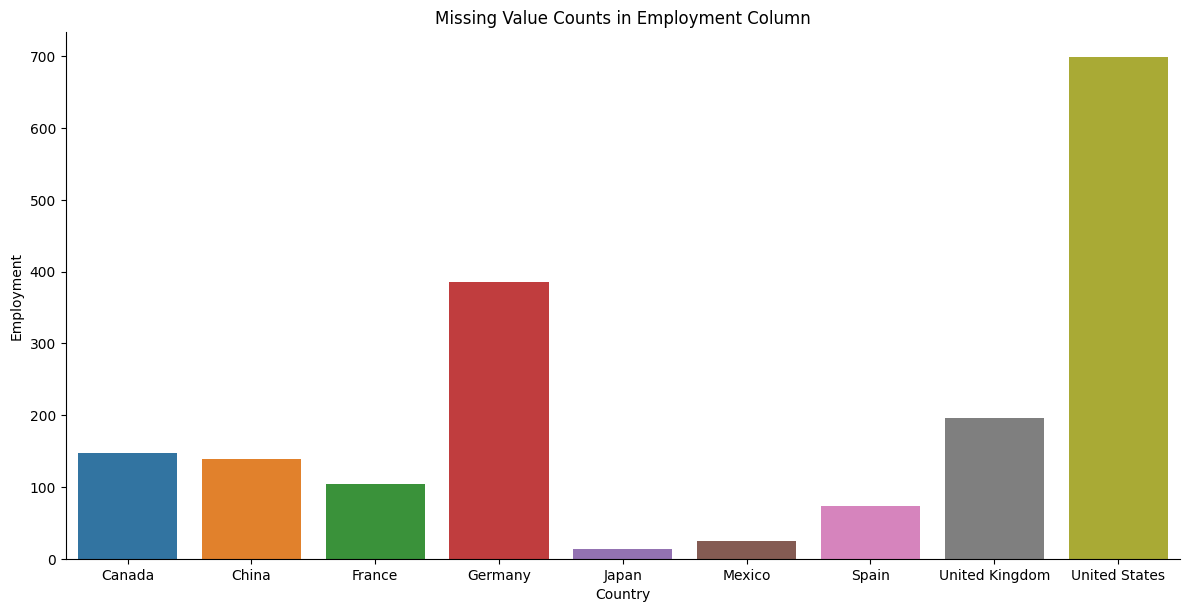

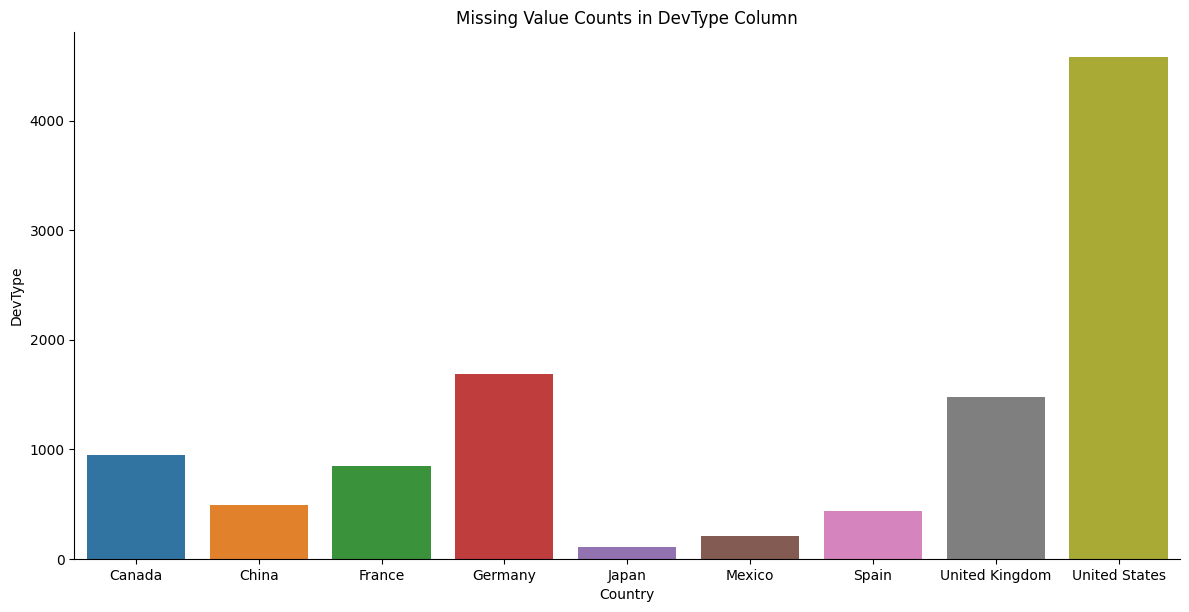

In [427]:
A = sns.catplot(data = missing_data, kind = "bar", x = "Country", y = "Employment", height=6, aspect=2)
plt.title("Missing Value Counts in Employment Column")

B = sns.catplot(data = missing_data, kind = "bar", x = "Country", y = "DevType", height=6, aspect=2)
plt.title("Missing Value Counts in DevType Column");

As we can see from the above plots, the data doesn’t appear to be missing for any country significantly more than any other. Using your domain knowledge, you understand that the missing data appears to scale with the relative size of each country (e.g. there is more missing data in the United States vs. Japan because there will be more respondents there). You also note that the United States and Germany have significantly more developers (on average) than the other countries, explaining why they have more missing data points.

You determine that the missing data for these two columns can be categorized as `MCAR(Missing Completely at Random)`. This means you can safely delete the rows that have missing data in these columns! This is a prime example of where you can employ Pairwise Deletion to only delete rows that have missing data for either `Employment` or `DevType`:

In [428]:
df.dropna(subset=["Employment", "DevType"], inplace=True, how = "any")

In [429]:
df.shape

(99975, 18)

In [430]:
# We will focus on a few of the key developer types outlined in the Stack Overflow Survey
df2 = df[["Country", "DevType"]]

df2.loc[df2["DevType"].str.contains("back-end|Back-end", regex=True), "BackEnd"] = True
df2.loc[df2["DevType"].str.contains("front-end|Front-end", regex=True), "FrontEnd"] = True
df2.loc[df2["DevType"].str.contains("full-stack|Full-stack", regex=True), "FullStack"] = True
df2.loc[df2["DevType"].str.contains("Back-end|Back-end", regex=True), "Backend"] = True
df2.loc[df2["DevType"].str.contains("mobile|Mobile", regex=True), "Mobile"] = True
df2.loc[df2["DevType"].str.contains("administrator", regex=True), "Admin"] = True

In [431]:
df2.head()

,Country,DevType,BackEnd,FrontEnd,FullStack,Backend,Mobile,Admin
0,United States,Engineering manager;Full-stack developer,NaN,NaN,True,NaN,NaN,NaN
1,United States,"Developer, full-stack",NaN,NaN,True,NaN,NaN,NaN
3,United States,Full-stack developer,NaN,NaN,True,NaN,NaN,NaN
4,United States,Data or business analyst;Database administrato...,True,True,True,NaN,True,True
5,United States,"Developer, back-end;Developer, desktop or ente...",True,NaN,NaN,NaN,NaN,NaN


In [432]:
df2 = df2.melt(id_vars=['Country'], 
               value_vars=['BackEnd','FrontEnd','FullStack','Mobile','Admin'], 
               var_name='DevCat',
               value_name='DevFlag')

In [433]:
df2.head()

,Country,DevCat,DevFlag
0,United States,BackEnd,NaN
1,United States,BackEnd,NaN
2,United States,BackEnd,NaN
3,United States,BackEnd,True
4,United States,BackEnd,True


In [434]:
df2.shape

(499875, 3)

In [435]:
df2.dropna(inplace=True)

In [436]:
df2.shape

(173767, 3)

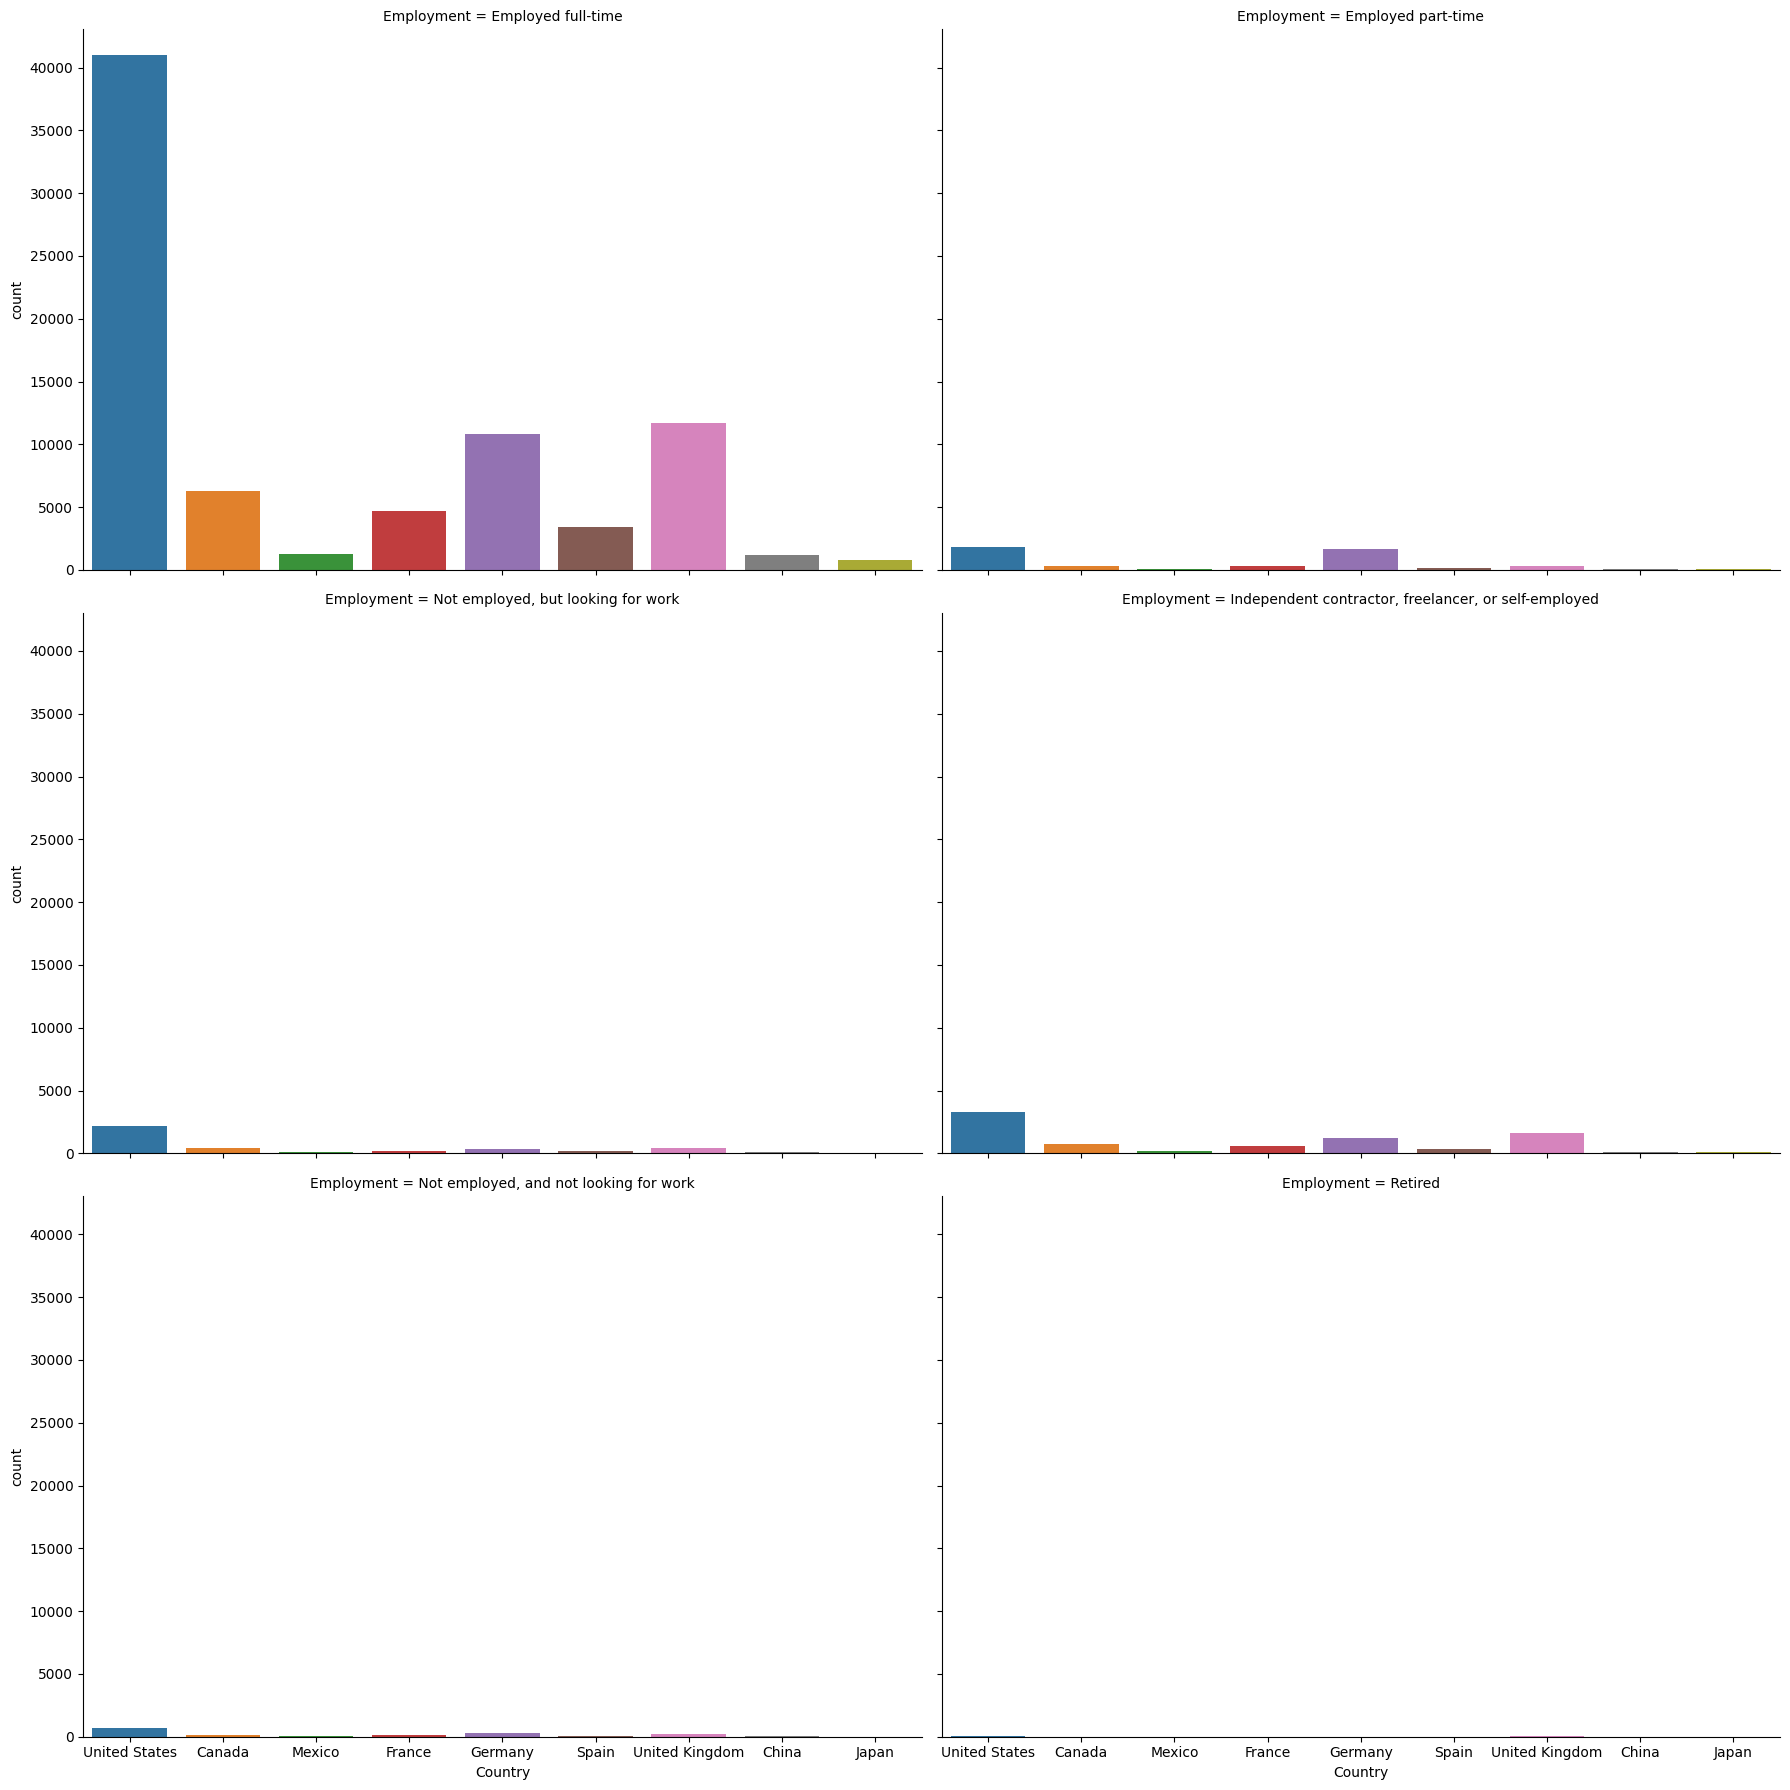

In [437]:
empfig = sns.catplot(x = "Country", col = "Employment", data = df, kind = "count", height=6, aspect = 1.5, col_wrap = 2)

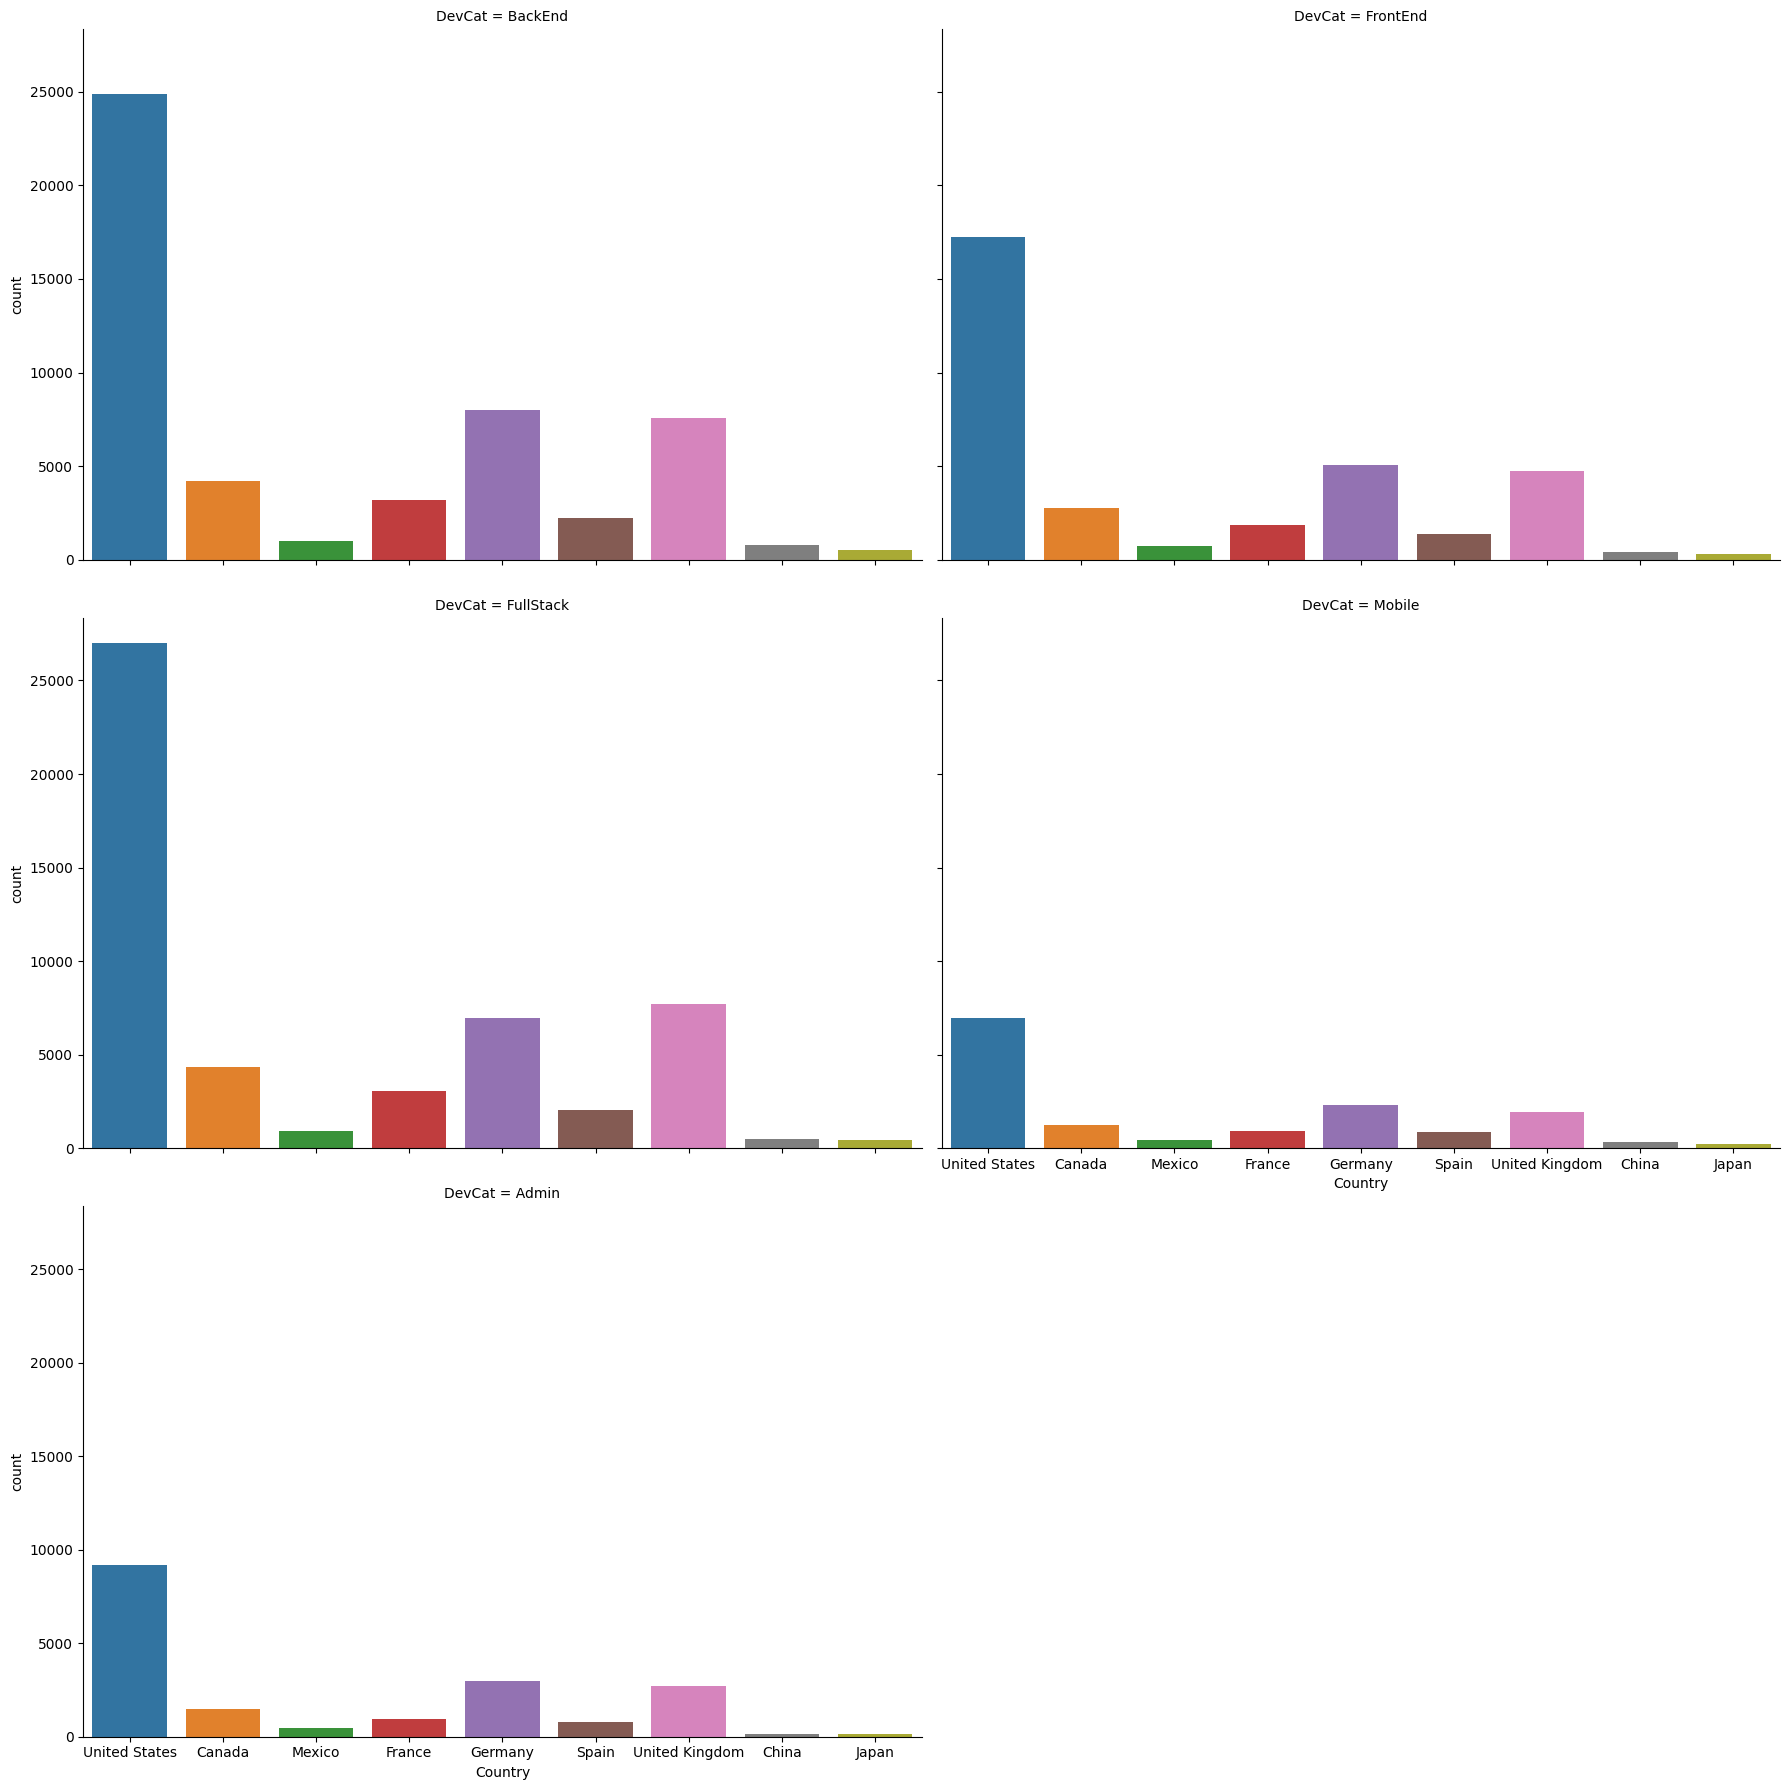

In [438]:
devfig = sns.catplot(x = "Country", col = "DevCat", data = df2, kind = "count", height=6, aspect=1.5, col_wrap = 2)

### Developer Undergrad Majors
You decide to dive into the background for each type of developer to see trends in their educational experience that ultimately led to a career with technology. In particular, you look at the overall trend of majors year over year for respondents. As you saw before, you are missing about 11% of the data for `UndergradMajor`. Why do you think this data is missing? Could something have happened over the course of these three years? Is the fact that data is missing accurate?

To test your theory, take a look at the distribution of majors over each year:

In [439]:
missing_undergrad = df["UndergradMajor"].isnull().groupby(df["Year"]).sum().reset_index()
missing_undergrad

,Year,UndergradMajor
0,2018,5559
1,2019,3831
2,2020,0


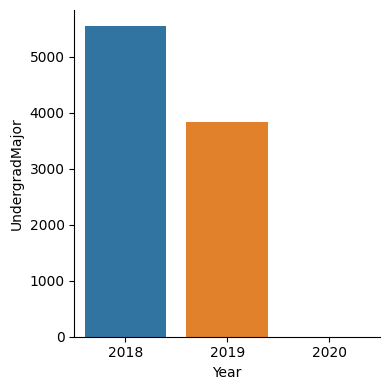

In [440]:
sns.catplot(x = "Year", y = "UndergradMajor", data = missing_undergrad, kind = "bar", height = 4, aspect = 1);

You see that all of the data for 2020 undergrad majors is filled in, indicating that each participant in these surveys had some level of decision for their undergrad major. For the purposes of your analysis, you are most interested in what major a person ultimately landed on, as this would be the educational background they would carry into a job search. You want to carry that value backwards for each participant to fill in any missing data. This is a great use for one of our Single Imputation techniques: NOCB! Fill in the gaps using NOCB:

In [441]:
# Make sure to sort by our ID and Year so that each person's data is carried backwards correctly
df.sort_values(["RespondentID", "Year"], inplace=True)
df["UndergradMajor"].bfill(axis = 0, inplace = True)

In [442]:
# We will focus on a few of the key major groups outlined in the Stack Overflow Survey
df3 = df[["Year", "UndergradMajor"]]
df3.dropna(inplace=True)
df3["UndergradMajor"].unique()

array(['Computer science, computer engineering, or software engineering',
       'Fine arts or performing arts (ex. graphic design, music, studio art)',
       'Information systems, information technology, or system administration',
       'A humanities discipline (such as literature, history, philosophy, etc.)',
       'A social science (ex. anthropology, psychology, political science)',
       'Web development or web design',
       'Another engineering discipline (ex. civil, electrical, mechanical)',
       'A humanities discipline (ex. literature, history, philosophy)',
       'Fine arts or performing arts (such as graphic design, music, studio art, etc.)',
       'A natural science (such as biology, chemistry, physics, etc.)',
       'A business discipline (ex. accounting, finance, marketing)',
       'Mathematics or statistics',
       'Another engineering discipline (such as civil, electrical, mechanical, etc.)',
       'A natural science (ex. biology, chemistry, physics)',
    

In [446]:
df3["UndergradMajor"].str.contains("development").sum()

3129

In [447]:
df3.loc[df3["UndergradMajor"].str.contains("social science"), "SocialScience"] = True
df3.loc[df3["UndergradMajor"].str.contains("natural science"), "NaturalScience"] = True
df3.loc[df3["UndergradMajor"].str.contains("computer science|Computer science", regex = True), "ComSci"] = True
df3.loc[df3["UndergradMajor"].str.contains("development"), "Dev"] = True
df3.loc[df3["UndergradMajor"].str.contains("another engineeering"), "OtherEng"] = True
df3.loc[df3["UndergradMajor"].str.contains("never declared"), "NoMajor"] = True

In [448]:
df3.head()

,Year,UndergradMajor,SocialScience,NaturalScience,ComSci,Dev,OtherEng,NoMajor
0,2018,"Computer science, computer engineering, or sof...",NaN,NaN,True,NaN,NaN,NaN
1,2019,"Computer science, computer engineering, or sof...",NaN,NaN,True,NaN,NaN,NaN
3,2018,"Computer science, computer engineering, or sof...",NaN,NaN,True,NaN,NaN,NaN
4,2019,"Computer science, computer engineering, or sof...",NaN,NaN,True,NaN,NaN,NaN
5,2020,"Computer science, computer engineering, or sof...",NaN,NaN,True,NaN,NaN,NaN


In [449]:
df3.shape

(99973, 8)

In [452]:
df3 = df3.melt(id_vars=["Year"], value_vars=["SocialScience", "NaturalScience", "ComSci", "OtherEng", "NoMajor", "Dev"],
         var_name="EduCat", value_name="EduFlag")
df3.head()

,Year,EduCat,EduFlag
0,2018,SocialScience,NaN
1,2019,SocialScience,NaN
2,2018,SocialScience,NaN
3,2019,SocialScience,NaN
4,2020,SocialScience,NaN


In [453]:
df3.dropna(inplace=True)

In [454]:
df3.shape

(73786, 3)

In [455]:
df3 = df3.groupby(["Year", "EduCat"]).count().reset_index()
df3

,Year,EduCat,EduFlag
0,2018,ComSci,24413
1,2018,Dev,1097
2,2018,NaturalScience,2171
3,2018,NoMajor,487
4,2018,SocialScience,1112
5,2019,ComSci,23331
6,2019,Dev,1399
7,2019,NaturalScience,2118
8,2019,NoMajor,506
9,2019,SocialScience,1024


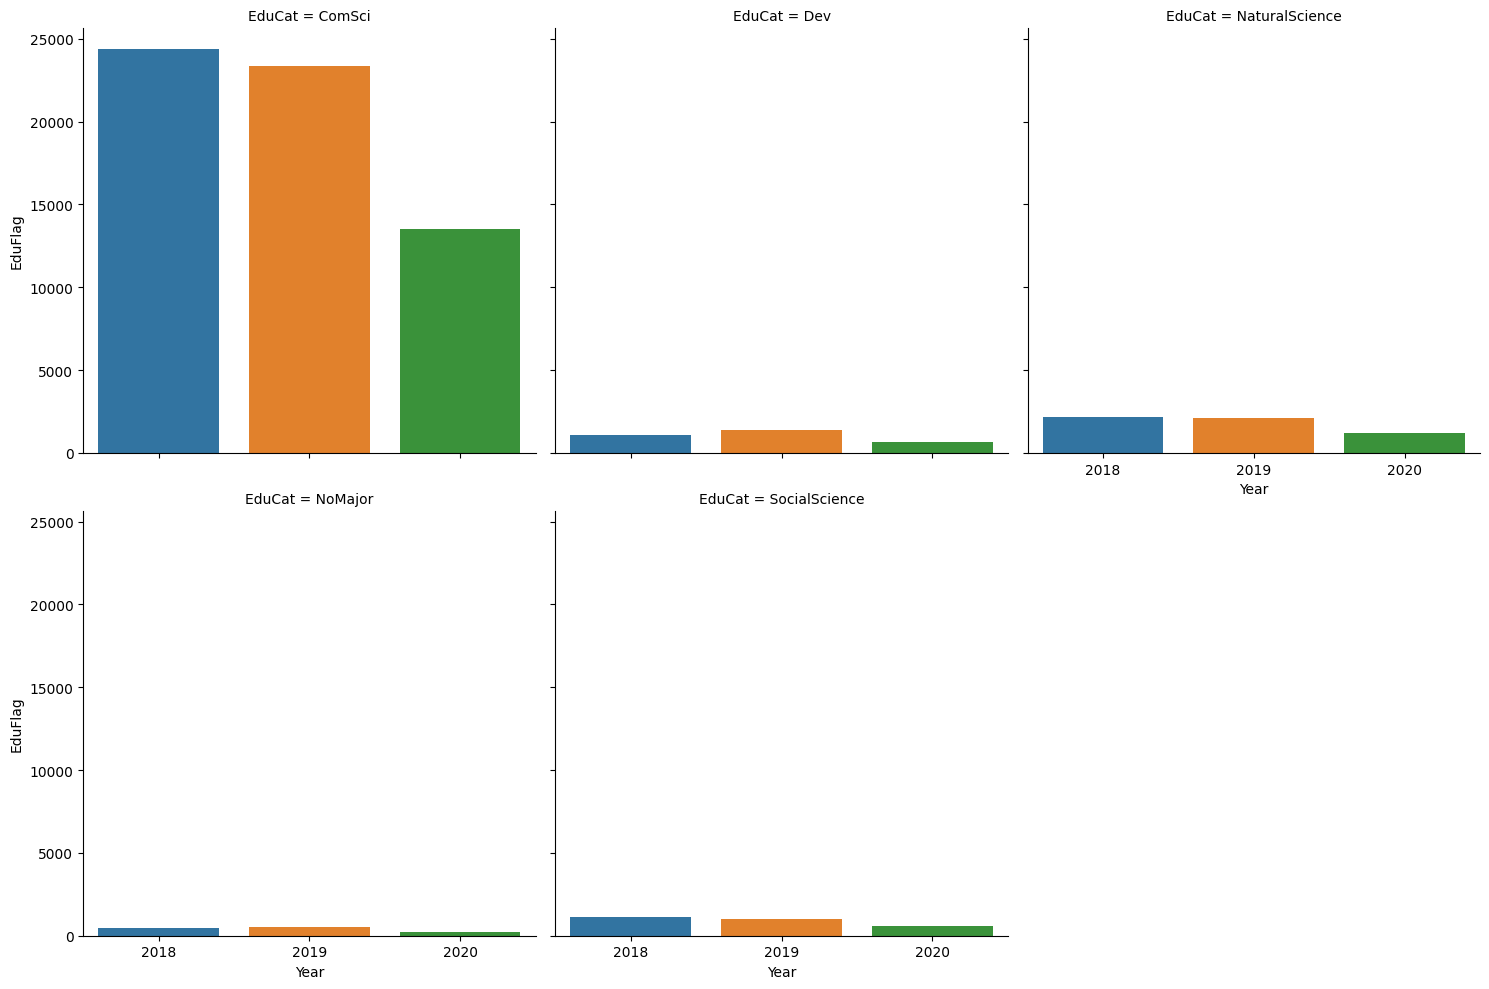

In [457]:
edu_fig = sns.catplot(x = "Year", y = "EduFlag", col = "EduCat", data = df3, kind = "bar", col_wrap=3)

You notice that the vast majority of people who enter the workforce for development have some background in a Computer Science major. Interestingly, however, the number of Computer Science majors significantly declined over the years surveyed, indicating that there could be other majors that have successfully entered the workforce for their desired job. This would require further analysis and could allow an individual to pursue a separate education path and still end up in some kind of developer role.

### Relationship between Years Experience and Compensation
At this point, you have studied the demographics of developers around the world, from where they live to the education paths they have taken. Now, you turn your focus to the various aspects that would influence the job-hunting process.

Years of experience are an important metric when looking to understand the general skill and technical capabilities of a potential candidate. Compensation is also important for our client to understand what the “going rate” for a particular developer is in today’s market. You might assume that there is a strong correlation between experience and job compensation, making it an excellent hypothesis to explore.

In order to understand a bit about the data for each of these two fields, perform some more exploratory analysis:

In [460]:
fields = df[["Year", "YearsCodePro", "ConvertedComp"]]
fields.head()

,Year,YearsCodePro,ConvertedComp
0,2018,NaN,141000.0
1,2019,1.0,61000.0
3,2018,4.0,48000.0
4,2019,8.0,90000.0
5,2020,13.0,116000.0


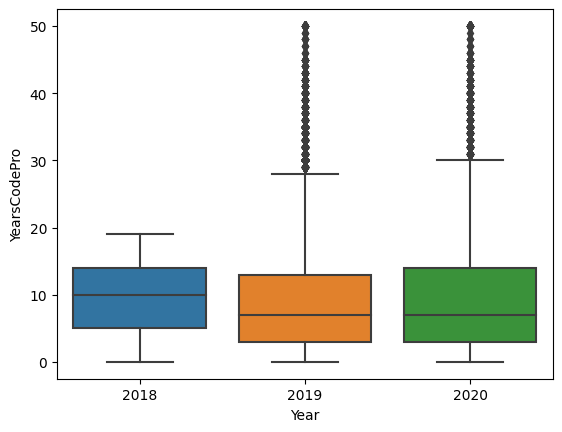

In [463]:
sns.boxplot(data = fields, x = "Year", y = "YearsCodePro");

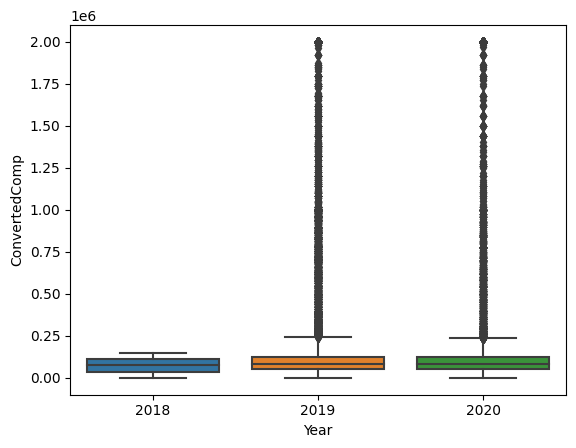

In [464]:
sns.boxplot(data = fields, x = "Year", y = "ConvertedComp");

You see that although there are some outlier data points for each column, the overall distribution is fairly consistent year-over-year. This indicates that there is a strong correlation between the data points, which should tell a good story about how experience can translate into compensation. Since there is a clear trend with the data points, you decide the best method for filling in the missing data for these two columns is through Multiple Imputation:

### Using IterativeImputer For Missing Values

In [466]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split

In [468]:
imputedf = df[["YearsCodePro", "ConvertedComp"]]
imputedf.head()

,YearsCodePro,ConvertedComp
0,NaN,141000.0
1,1.0,61000.0
3,4.0,48000.0
4,8.0,90000.0
5,13.0,116000.0


In [469]:
train, test = train_test_split(imputedf, train_size=0.1)

In [471]:
# Create the IterativeImputer model to predict missing values
imp_model = IterativeImputer(max_iter = 20, random_state=0)

# Fit the model to the test dataset
imp_model.fit(imputedf)

# Transform the model on the entire dataset
compdf = pd.DataFrame(np.round(imp_model.transform(imputedf), 0), columns=["YearsCodePro", "ConvertedComp"])

In [473]:
compdf.isnull().sum()

YearsCodePro     0
ConvertedComp    0
dtype: int64

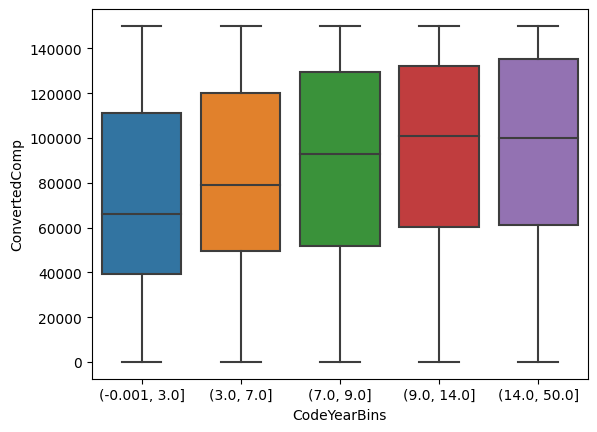

In [486]:
# Reducing our range for viewing simplicity

compPlotdf = compdf.loc[compdf['ConvertedComp'] <= 150000]
compPlotdf['CodeYearBins'] = pd.qcut(compPlotdf['YearsCodePro'], q=5)

sns.boxplot(x="CodeYearBins", y="ConvertedComp",
            data=compPlotdf);

The plot above validates your hypothesis from before. While there are high (and low) earning developers at every experience level, experience appears to correlate with compensation. The more experienced a developer was, the more (on average) they were compensated.

In [487]:
df.to_csv('developer_dataset_cleaned.csv', index=False, header=True)